### Route segmentation 

Explanation of the segmentation of a route (.gpx format ) in logical segments ( ascent, descent, flat ) 

In [1]:
import gpxpy
import pandas as pd
import numpy as np
import folium
from folium import plugins
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from math import radians, cos, sin, asin, sqrt
import warnings
warnings.filterwarnings('ignore')


In [2]:
def sign_equal(a, b):
    """
    Compares the two-digit sign and indicates whether they are identical
    Takes the 0 as a separate value
    ex : sign_equal(0,-5) >>> False
    Return True/False
    """
    return np.sign(a) == np.sign(b)

In [3]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    m = km * 1000
    return m

#### Gpx Parser

the example file represents the mythical ascent of alpe d'huez ( France ) ...

In [4]:
gpx_file = "datas/example.gpx"
parsed_gpx = gpxpy.parse(open(gpx_file))

In [5]:
data = [
    {"latitude": point.latitude, "longitude": point.longitude, "elevation": point.elevation}
    for track in parsed_gpx.tracks
    for segment in track.segments
    for point in segment.points
]

In [6]:
df = pd.DataFrame(data)
df["elevation"] = round(df["elevation"],2)
df.head(5)

,latitude,longitude,elevation
0,45.054760,6.03177,722.02
1,45.054750,6.03199,721.97
2,45.054890,6.03240,721.56
3,45.055110,6.03276,721.56
4,45.055505,6.03322,721.31


In [7]:
df.shape

(479, 3)

In [8]:
df.dtypes

latitude     float64
longitude    float64
elevation    float64
dtype: object

### Compute informations Route

#### Distance

In [9]:
# distance to the last point 
for i in range(df.shape[0]):
    if i == 0:
        df.loc[i,"distance_to_last_point"] = 0
    else:
        df.loc[i,"distance_to_last_point"] = round(haversine(df['longitude'][i],df['latitude'][i],df['longitude'][i-1],df['latitude'][i-1]),2)

df.head(5)

,latitude,longitude,elevation,distance_to_last_point
0,45.054760,6.03177,722.02,0.00
1,45.054750,6.03199,721.97,17.32
2,45.054890,6.03240,721.56,35.77
3,45.055110,6.03276,721.56,37.39
4,45.055505,6.03322,721.31,56.87


In [10]:
df['total_distance'] = round(df['distance_to_last_point'].cumsum(),2)
df.head(5)

,latitude,longitude,elevation,distance_to_last_point,total_distance
0,45.054760,6.03177,722.02,0.00,0.00
1,45.054750,6.03199,721.97,17.32,17.32
2,45.054890,6.03240,721.56,35.77,53.09
3,45.055110,6.03276,721.56,37.39,90.48
4,45.055505,6.03322,721.31,56.87,147.35


#### Altitude Gain Rolling Windows

Calculation of altitude differences between two points with a rolling window 

The goal here is to "absorb" the slight variations of the road, in fact we don't want to have many short flat section in a very long ascent.

In [11]:
df['rw_altitude_gain'] = df['elevation'].rolling(window=6).apply(lambda x: x.iloc[5]-x.iloc[0])
df.head(10)

,latitude,longitude,elevation,distance_to_last_point,total_distance,rw_altitude_gain
0,45.054760,6.031770,722.02,0.00,0.00,NaN
1,45.054750,6.031990,721.97,17.32,17.32,NaN
2,45.054890,6.032400,721.56,35.77,53.09,NaN
3,45.055110,6.032760,721.56,37.39,90.48,NaN
4,45.055505,6.033220,721.31,56.87,147.35,NaN
5,45.055900,6.033680,721.18,56.87,204.22,-0.84
6,45.056370,6.034200,721.22,66.33,270.55,-0.75
7,45.056840,6.034720,721.69,66.33,336.88,0.13
8,45.057430,6.035395,723.39,84.35,421.23,1.83
9,45.058020,6.036070,725.51,84.35,505.58,4.20


#### Visualization

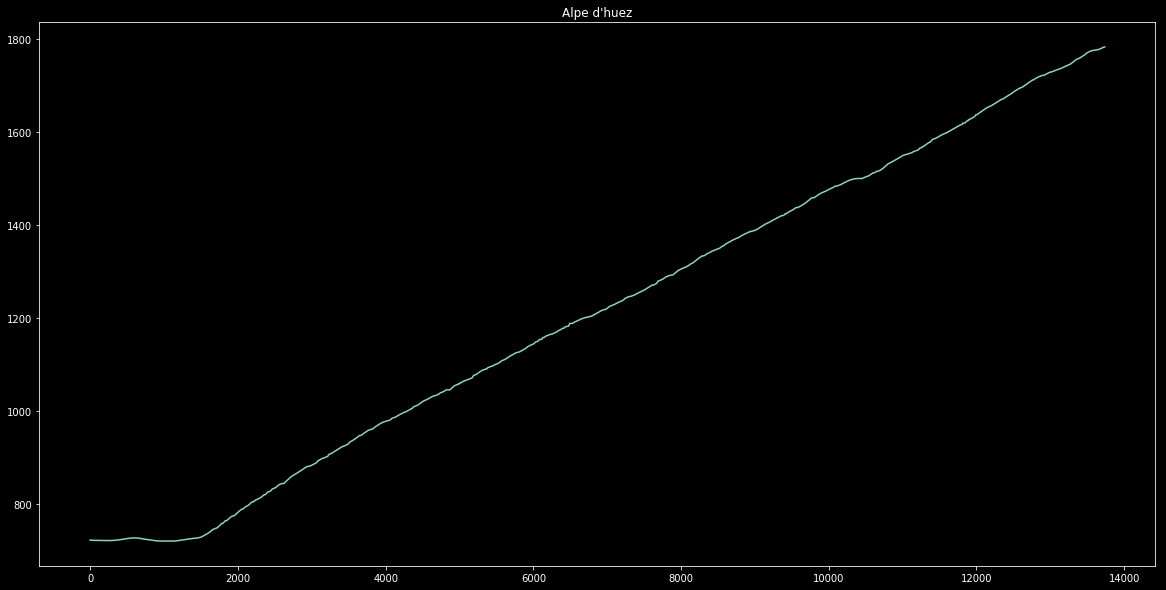

In [12]:
plt.style.use('dark_background')
plt.figure(figsize=(20,10))
plt.plot(df['total_distance'],df['elevation'])
plt.title("Alpe d'huez")
plt.show()

It looks like the ascent of the Alpe d'huez...

### Rolling Windows Explication

- altitude gained or lost with each step
- Below zero, downhill
- Above zero, uphill
- The curve goes down with a positive value, We keep going up but the slope is less steep 
- The curve goes up with a negative value, We continue to go down but the slope becomes softer

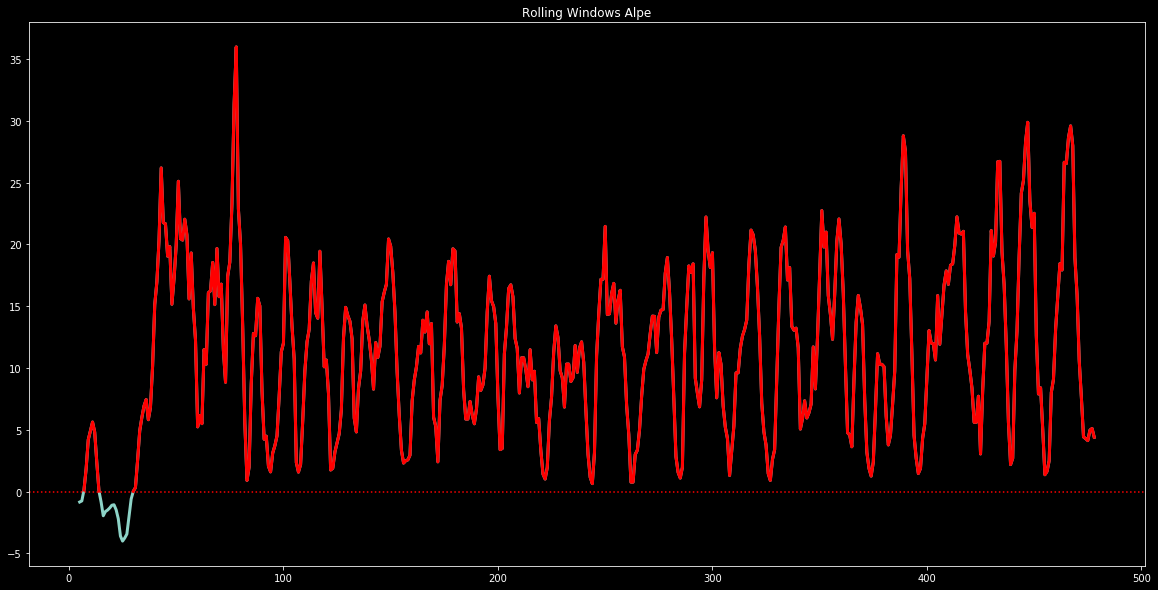

In [13]:
a = np.array(df['rw_altitude_gain'])
# Mask with values greater than or equal to zero
a_masked = np.ma.masked_less_equal(a, 0)

plt.style.use('dark_background')
plt.figure(figsize=(20,10))
plt.plot(a,linewidth=3)
plt.plot(a_masked,color='red',linewidth=3)
plt.axhline(y=0, color='r', linestyle='dotted')
plt.title("Rolling Windows Alpe")
plt.show()

#### Segmentation 

In [14]:
df_na = df[df['rw_altitude_gain'].isna()]
df_na['segment'] = 0
df_na

,latitude,longitude,elevation,distance_to_last_point,total_distance,rw_altitude_gain,segment
0,45.054760,6.03177,722.02,0.00,0.00,NaN,0
1,45.054750,6.03199,721.97,17.32,17.32,NaN,0
2,45.054890,6.03240,721.56,35.77,53.09,NaN,0
3,45.055110,6.03276,721.56,37.39,90.48,NaN,0
4,45.055505,6.03322,721.31,56.87,147.35,NaN,0


In [15]:
df = df.dropna().reset_index(drop=True)
df.head(5)

,latitude,longitude,elevation,distance_to_last_point,total_distance,rw_altitude_gain
0,45.05590,6.033680,721.18,56.87,204.22,-0.84
1,45.05637,6.034200,721.22,66.33,270.55,-0.75
2,45.05684,6.034720,721.69,66.33,336.88,0.13
3,45.05743,6.035395,723.39,84.35,421.23,1.83
4,45.05802,6.036070,725.51,84.35,505.58,4.20


In [16]:
for i in range(df.shape[0]):
    if i == 0 : 
        df.loc[i,"segment"] = 0
    else:
        if not sign_equal(df.loc[i-1,'rw_altitude_gain'], df.loc[i,"rw_altitude_gain"]):
            df.loc[i,"segment"] = df.loc[i-1,"segment"] + 1 
        else:
            df.loc[i,"segment"] = df.loc[i-1,"segment"]

df

,latitude,longitude,elevation,distance_to_last_point,total_distance,rw_altitude_gain,segment
0,45.05590,6.033680,721.18,56.87,204.22,-0.84,0.0
1,45.05637,6.034200,721.22,66.33,270.55,-0.75,0.0
2,45.05684,6.034720,721.69,66.33,336.88,0.13,1.0
3,45.05743,6.035395,723.39,84.35,421.23,1.83,1.0
4,45.05802,6.036070,725.51,84.35,505.58,4.20,1.0
...,...,...,...,...,...,...,...
469,45.09049,6.065350,1779.48,10.94,13684.01,4.29,3.0
470,45.09055,6.065430,1780.29,9.16,13693.17,4.13,3.0
471,45.09068,6.065490,1781.73,15.20,13708.37,4.98,3.0
472,45.09088,6.065460,1783.31,22.36,13730.73,5.11,3.0


In [17]:
df = df_na.append(df, ignore_index=True)
df

,latitude,longitude,elevation,distance_to_last_point,total_distance,rw_altitude_gain,segment
0,45.054760,6.03177,722.02,0.00,0.00,NaN,0.0
1,45.054750,6.03199,721.97,17.32,17.32,NaN,0.0
2,45.054890,6.03240,721.56,35.77,53.09,NaN,0.0
3,45.055110,6.03276,721.56,37.39,90.48,NaN,0.0
4,45.055505,6.03322,721.31,56.87,147.35,NaN,0.0
...,...,...,...,...,...,...,...
474,45.090490,6.06535,1779.48,10.94,13684.01,4.29,3.0
475,45.090550,6.06543,1780.29,9.16,13693.17,4.13,3.0
476,45.090680,6.06549,1781.73,15.20,13708.37,4.98,3.0
477,45.090880,6.06546,1783.31,22.36,13730.73,5.11,3.0


### Start & End indexs of each segment

In [18]:
all_segments_index = []

for i in df['segment'].unique():
    segment_index = {}
    segment_df = df.loc[df['segment'] == i]
    if i == 0 : 
        segment_index['start'] = segment_df.head(1).index.values[0]
    else:
        segment_index['start'] = segment_df.head(1).index.values[0] - 1
        
    segment_index['end'] = segment_df.tail(1).index.values[0]
    all_segments_index.append(segment_index)
    
all_segments_index

[{'start': 0, 'end': 6},
 {'start': 6, 'end': 14},
 {'start': 14, 'end': 29},
 {'start': 29, 'end': 478}]

### Compute informations segments

In [19]:
segments = []
for i in range(len(all_segments_index)):
    segment = {}
    segment_df = df.loc[all_segments_index[i].get("start"):all_segments_index[i].get("end")]
    if i == 0:
        distance = segment_df.tail(1)['total_distance'].values[0]
    else:
        distance = segment_df.tail(1)['total_distance'].values[0] - segment_df.head(1)['total_distance'].values[0]
    
    altitude_gain = segment_df.tail(1)['elevation'].values[0] - segment_df.head(1)['elevation'].values[0]
    vertical_drop = (altitude_gain * 100) / distance
    
    # all points of a segment
    
    all_points = []
    for latitude, longitude in zip(segment_df['latitude'].values, segment_df['longitude'].values):
        point = [latitude,longitude]
        all_points.append(point)
    
    segment['distance'] = float(round(distance,2))
    segment['altitude_gain'] = float(round(altitude_gain,2))
    segment['vertical_drop'] = float(round(vertical_drop,2))
    segment['all_points'] = all_points
    segments.append(segment)

segments
        

[{'distance': 270.55,
  'altitude_gain': -0.8,
  'vertical_drop': -0.3,
  'all_points': [[45.05476, 6.031770000000001],
   [45.054750000000006, 6.03199],
   [45.05489, 6.032400000000001],
   [45.055110000000006, 6.032760000000001],
   [45.055505000962, 6.033219996867681],
   [45.0559, 6.03368],
   [45.056370001328915, 6.034199995890939]]},
 {'distance': 422.22,
  'altitude_gain': 4.33,
  'vertical_drop': 1.03,
  'all_points': [[45.056370001328915, 6.034199995890939],
   [45.05684, 6.03472],
   [45.057430002033655, 6.035394993087481],
   [45.058020000000006, 6.0360700000000005],
   [45.05816, 6.036250000000001],
   [45.05853500144694, 6.0368149963759725],
   [45.058910000000004, 6.037380000000001],
   [45.05904, 6.03774],
   [45.059050000000006, 6.0379000000000005]]},
 {'distance': 427.89,
  'altitude_gain': -5.51,
  'vertical_drop': -1.29,
  'all_points': [[45.059050000000006, 6.0379000000000005],
   [45.05912000000001, 6.03802],
   [45.059160000000006, 6.03805],
   [45.05917, 6.038060

In [20]:
segments_df = pd.DataFrame(segments)
segments_df

,distance,altitude_gain,vertical_drop,all_points
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000..."
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45...."
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45..."
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000..."


### Verification

In [21]:
import unittest

In [22]:
class TestSegmentationRoute(unittest.TestCase):
    
    def test_segmentation_distance(self):
        expected = df["total_distance"].tail(1).values[0]
        actual = 0
        for segment in segments:
            actual += segment.get("distance")
        self.assertEqual(actual,expected)
        
    def test_segmentation_elevation(self):
        expected = df["elevation"].tail(1).values-df['elevation'].head(1).values
        actual = 0
        for segment in segments:
            actual += segment.get("altitude_gain")
        self.assertEqual(actual,expected)

In [23]:
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

..
----------------------------------------------------------------------
Ran 2 tests in 0.005s

OK


There is no loss of information in the segmentation, total distance and total altitude gain are similar to the input data.

### Visualization

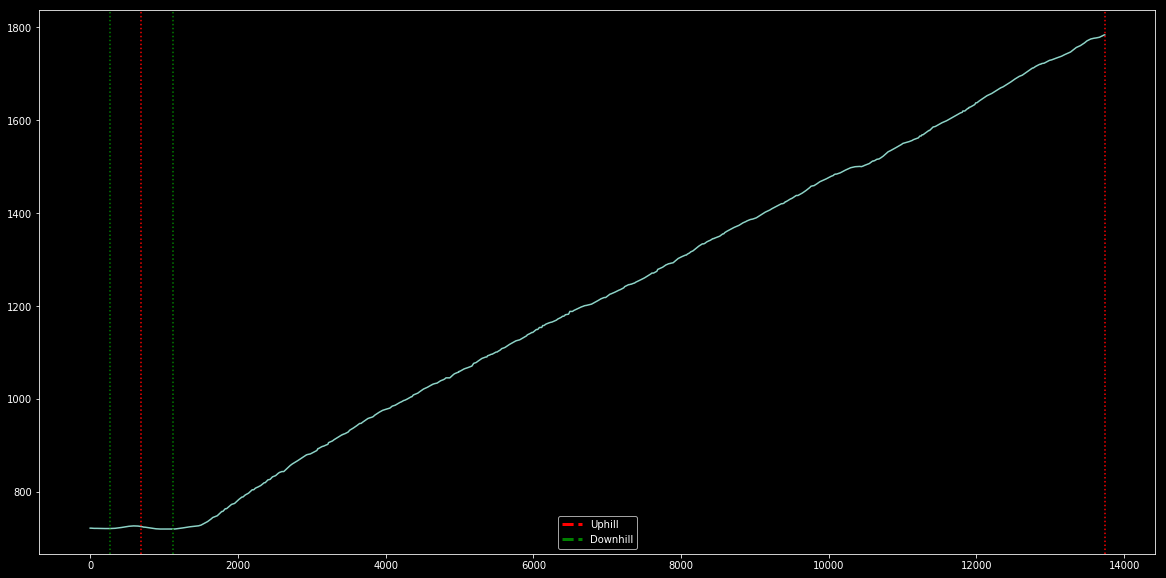

In [24]:
plt.style.use('dark_background')
plt.figure(figsize=(20,10))
plt.plot(df['total_distance'],df['elevation'])

total_distance = 0
for i in range(len(segments)):
    total_distance += segments[i].get("distance")
    if segments[i].get("vertical_drop") <= 0:
        plt.axvline(x=total_distance, color='green', linestyle='dotted')
    else:
         plt.axvline(x=total_distance, color='red', linestyle='dotted')
            
colors = ['red', 'green']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in colors]
labels = ['Uphill', 'Downhill']
plt.legend(lines, labels)
plt.show()

It looks like a correct segmentation...

In [83]:
middle_point = round(df.shape[0] / 2)



m = folium.Map(
    location = [df['latitude'][middle_point],df['longitude'][middle_point]],
    zoom_start = 13,
    tiles="OpenStreetMap"
)

for segment in segments:
    if segment.get("vertical_drop") < 0:
        
        line = folium.PolyLine(
            locations = segment.get("all_points"),
            weight=3,
            color="green"
        ).add_to(m)
        
    elif segment.get("vertical_drop") > 0 :
        
        line = folium.PolyLine(
            locations = segment.get("all_points"),
            weight=3,
            color="red"
        ).add_to(m)
    
    # flat
    else:
        line = folium.PolyLine(
            locations = segment.get("all_points"),
            weight=3,
            color="black"
        ).add_to(m)
              
m

![Obama Drop The Mic](https://media.giphy.com/media/3o7qDSOvfaCO9b3MlO/giphy.gif "Obama Drop the mic")